In [1]:
# for auto-reload user code (imported py file) on each execution of code from it
# need to be executed only once
%load_ext autoreload
%autoreload 2

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
spark = SparkSession.builder.config("spark.sql.warehouse.dir",
                                    "file:///C:/temp").appName("loans").getOrCreate()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plot_utils_spark
import utils
import numpy as np
# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
# from sklearn.feature_extraction import DictVectorizer
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
# from sklearn.svm import LinearSVC, SVC
# from sklearn.feature_selection import SelectFromModel, RFECV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.naive_bayes import BernoulliNB, GaussianNB

sns.set()
% matplotlib inline

## TODO
categorize numerical features using pandas.cut, pandas.qcut or numpy.histogram

first glance at the dataset:

In [5]:
df = spark.read.csv('dataset.csv', header=True, inferSchema=True)
df

DataFrame[checking_status: string, duration: int, credit_history: string, purpose: string, credit_amount: int, savings_status: string, employment: string, installment_commitment: int, personal_status: string, other_parties: string, residence_since: int, property_magnitude: string, age: int, other_payment_plans: string, housing: string, existing_credits: int, job: string, num_dependents: int, own_telephone: string, foreign_worker: string, class: string]

In [6]:
# function to sample dataframe relative to its size .
# use case example: plot a distribution
def sample_df(df, by=None, byFractions = None, seed=None):
    df_len = df.count()
    sample_frac = 1.0
    if df_len > 10000:
        sample_frac = 10000 / df_len
    if by:
        if byFractions:
            fractions = byFractions
        else:
            fractions = df.groupby(by).agg(F.lit(sample_frac)).rdd.collectAsMap()
        return df.sampleBy(by,fractions,seed)
    return df.sample(False, sample_frac, seed)    

In [7]:
%%time
df.limit(5).toPandas()

Wall time: 252 ms


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


# Reports

### Credit amount as function of purpose

graph:

In [8]:
n_samples = df.count()

C:\Users\Yair\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


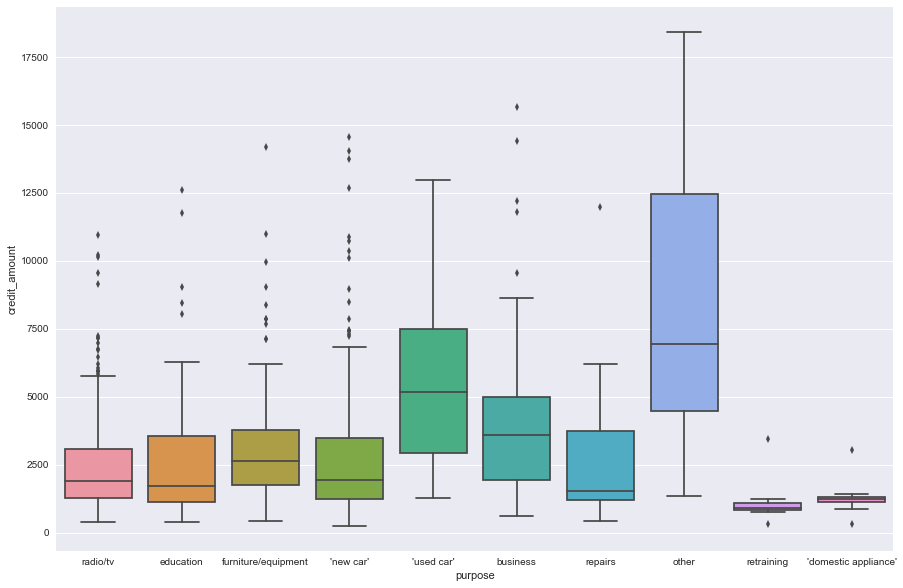

In [9]:
# in general, when we deal with big data and we need to plot distributions, we need to sample
# the data for sake of time efficiency. Ofcourse the sample need to be stratified according to
# the chosen categories (in our case by "purpose"). Here, because the dataset is very small I 
# choose sample of 0.8. In case of big data that should be fitted to memory and can be 0.01 or even less.
fractions = df.groupby("purpose").agg(F.lit(0.8)).rdd.collectAsMap()
#fractions = df.select('purpose').distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap() # another option
plt.figure(figsize=(15,10))
sns.boxplot(x="purpose", y="credit_amount", data=df.sampleBy("purpose",fractions).toPandas())

In general the credits are higher for used car or buisness loans.

table:

In [10]:
from pyspark.sql import functions as F
# in pandas we can get the statistics easily by:
# grouped['credit_amount'].describe().sort_values('mean', ascending = False)
# since a pandas groupby object has describe() method. Unfortunley, a pyspark.sql groupby
# object doesn't have one so we need to define it explicitly:

grouped = df.groupby('purpose')
agg_funcs = ['avg', 'max', 'min', 'sum', 'count']
aggFuncList = [eval('F.' + agg_func + '(df.credit_amount)') for agg_func in agg_funcs] 
grouped.agg(*aggFuncList).toPandas().sort_values('avg(credit_amount)', ascending = False)

,purpose,avg(credit_amount),max(credit_amount),min(credit_amount),sum(credit_amount),count(credit_amount)
4,other,8209.333333,18424,1164,98512,12
5,'used car',5370.223301,12976,1236,553133,103
7,business,4158.041237,15945,609,403330,97
1,education,3180.400000,12612,392,159020,50
9,furniture/equipment,3066.988950,14179,428,555125,181
2,'new car',3063.025641,14896,250,716748,234
8,repairs,2728.090909,11998,454,60018,22
0,radio/tv,2487.653571,15653,338,696543,280
3,'domestic appliance',1498.000000,3990,343,17976,12
6,retraining,1205.888889,3447,339,10853,9


### Total amount of loans greater than 10,000 that were given to unemployed males over the age of 30 

In [11]:
df.select('personal_status').distinct().show()

+--------------------+
|     personal_status|
+--------------------+
|'female div/dep/mar'|
|      'male div/sep'|
|       'male single'|
|      'male mar/wid'|
+--------------------+



In [12]:
(df[(df['personal_status'] != "'female div/dep/mar'") &
          (df['employment'] == "unemployed") &
          (df['age'] > 30) &
          (df['credit_amount'] > 10000)]).select(F.sum('credit_amount')).show()

+------------------+
|sum(credit_amount)|
+------------------+
|             28026|
+------------------+



### Credit Amount distribution as function of personal status

graph:

C:\Users\Yair\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\Yair\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


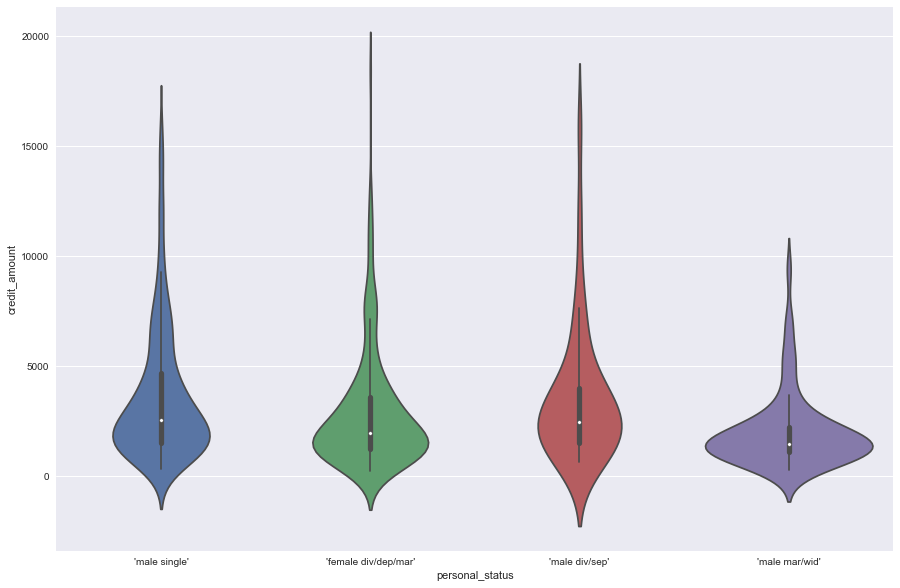

In [13]:
fractions = df.groupby("personal_status").agg(F.lit(0.8)).rdd.collectAsMap()
plt.figure(figsize=(15,10))
sns.violinplot(x="personal_status", y="credit_amount", data=df.sampleBy("personal_status",fractions).toPandas())

table:

In [14]:
grouped = df.groupby('personal_status')
grouped.agg(*aggFuncList).toPandas().sort_values('avg(credit_amount)', ascending = False)

,personal_status,avg(credit_amount),max(credit_amount),min(credit_amount),sum(credit_amount),count(credit_amount)
1,'male div/sep',3684.700000,15857,640,184235,50
2,'male single',3661.903285,15945,338,2006723,548
0,'female div/dep/mar',2877.774194,18424,250,892110,310
3,'male mar/wid',2045.543478,9398,276,188190,92


### Number of Customers who are employed over 4 years

In [15]:
df.select('employment').distinct().show()

+----------+
|employment|
+----------+
|  '4<=X<7'|
|     '>=7'|
|  '1<=X<4'|
|      '<1'|
|unemployed|
+----------+



In [16]:
df[(df['employment'] == "'>=7'") | (df['employment'] == "'4<=X<7'")].count()

427

## Train a Model, Test and Evaluate

split to train and test:

In [17]:
TRAIN_FRAC = 0.8
df_train, df_test = df.randomSplit([TRAIN_FRAC, 1-TRAIN_FRAC], seed=42)
df_train.limit(5).toPandas()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'0<=X<200',6,'all paid','new car',931,'100<=X<500','<1',1,'female div/dep/mar',none,...,'life insurance',32,stores,own,1,'unskilled resident',1,none,yes,bad
1,'0<=X<200',6,'delayed previously',business,1449,'100<=X<500','>=7',1,'male div/sep',none,...,car,31,bank,own,2,skilled,2,none,yes,good
2,'0<=X<200',6,'delayed previously',furniture/equipment,1050,'<100',unemployed,4,'male single',none,...,'life insurance',35,stores,own,2,'high qualif/self emp/mgmt',1,yes,yes,good
3,'0<=X<200',6,'existing paid','new car',14555,'no known savings',unemployed,1,'male single',none,...,'life insurance',23,none,own,1,'unemp/unskilled non res',1,yes,yes,bad
4,'0<=X<200',6,'existing paid',radio/tv,368,'no known savings','>=7',4,'male single',none,...,'life insurance',38,none,own,1,skilled,1,none,yes,good


In [18]:
#sampled version for df_train for plotting purpose:
samp_df_train = sample_df(df_train)

In [19]:
df_train.subtract(samp_df_train).count()

0

check the types of the columns:

In [20]:
df_train.dtypes

[('checking_status', 'string'),
 ('duration', 'int'),
 ('credit_history', 'string'),
 ('purpose', 'string'),
 ('credit_amount', 'int'),
 ('savings_status', 'string'),
 ('employment', 'string'),
 ('installment_commitment', 'int'),
 ('personal_status', 'string'),
 ('other_parties', 'string'),
 ('residence_since', 'int'),
 ('property_magnitude', 'string'),
 ('age', 'int'),
 ('other_payment_plans', 'string'),
 ('housing', 'string'),
 ('existing_credits', 'int'),
 ('job', 'string'),
 ('num_dependents', 'int'),
 ('own_telephone', 'string'),
 ('foreign_worker', 'string'),
 ('class', 'string')]

In [21]:
strings = [feature for feature, dtype in df_train.dtypes if dtype == 'string']
ints = [feature for feature, dtype in df_train.dtypes if dtype == 'int']

statistics of the numerical columns:

In [22]:
df_desc = df_train[ints].describe().toPandas()
df_quantiles = pd.DataFrame(df_train.approxQuantile(ints,[0.25,0.5,0.75],0), index = ints).transpose()
df_quantiles['summary'] = ['25%','50%','75%']
df_desc = df_desc.append(df_quantiles, sort = False).reset_index(drop=True)
index = df_desc.index.tolist()
index = index[:4] + index[-3:] + [index[4]]
df_desc.reindex(index)

,summary,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
0,count,806,806,806,806,806,806,806
1,mean,21.049627791563275,3277.681141439206,2.956575682382134,2.8436724565756824,35.42679900744417,1.4081885856079404,1.150124069478908
2,stddev,12.166955293068384,2843.3991867956215,1.1198270434797244,1.1046500975076445,11.259071216035123,0.5905108382625797,0.35741478173482033
3,min,4,250,1,1,19,1,1
5,25%,12,1355,2,2,27,1,1
6,50%,18,2302,3,3,33,1,1
7,75%,24,4020,4,4,42,2,1
4,max,60,15945,4,4,75,4,2


1. From the numeric columns, only duration, credit amount and age can be treated as numbers and the rest as categoricals.
2. There are no missing values.

statistics of the categorical columns:

In [23]:
# less efficient version: loop on cols for all the 4 statistics
agg_funcs = ['count','countDistinct']
desc_df = pd.DataFrame(columns= ['feature',*agg_funcs])
top = []
freq = []
for col in strings:
    desc_df = desc_df.append(df_train.select([eval('F.' + agg_func)(col).alias(agg_func) 
                     for agg_func in agg_funcs]).
                       withColumn('feature',F.lit(col)).
                       toPandas(), sort = False)
    top_freq = df_train.groupby(col).agg(F.count(col).alias('count')).toPandas().max()
    top.append(top_freq[col])
    freq.append(top_freq['count'])
desc_df['top'] = top
desc_df['freq'] = freq
desc_df = desc_df.set_index('feature').transpose()
desc_df.columns.name = None
desc_df

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,class
count,806,806,806,806,806,806,806,806,806,806,806,806,806,806
countDistinct,4,5,10,5,5,4,3,4,3,3,4,2,2,2
top,'no checking','no credits/all paid',retraining,'no known savings',unemployed,'male single',none,car,stores,rent,skilled,yes,yes,good
freq,310,430,227,475,272,435,730,277,667,576,511,484,774,569


In [24]:
# more efficien version: loop on the statistic functions for the built-in ones (count and countDistinct)
# and on the columns for the ones that need seperate groupby on each feature (top and freq)
agg_funcs = ['count','countDistinct']
desc_df = pd.DataFrame(columns= ['agg_func',*strings])
for agg_func in agg_funcs:
    desc_df = desc_df.append(df_train.select([eval('F.' + agg_func)(col).alias(col) 
                     for col in strings]).
                       withColumn('agg_func',F.lit(agg_func)).
                       toPandas(), sort = False)
top = []
freq = []
for col in strings:
    top_freq = df_train.groupby(col).agg(F.count(col).alias('count')).toPandas().max()
    top.append(top_freq[col])
    freq.append(top_freq['count'])
top_freq_df = pd.DataFrame([top,freq], columns=strings, index = ['top','freq'])
desc_df = desc_df.set_index('agg_func')
desc_df.columns.name = None
desc_df = desc_df.append(top_freq_df)
desc_df

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,class
count,806,806,806,806,806,806,806,806,806,806,806,806,806,806
countDistinct,4,5,10,5,5,4,3,4,3,3,4,2,2,2
top,'no checking','no credits/all paid',retraining,'no known savings',unemployed,'male single',none,car,stores,rent,skilled,yes,yes,good
freq,310,430,227,475,272,435,730,277,667,576,511,484,774,569


1. It seems that all the categoricals features have small amount of unique values - no need in aggregation
2. No missing values

In [25]:
# efficency check: to list or toPandas?
# answer: same time
%time [row.age for row in df_train.select('age').collect()]
%time df_train.select('age').toPandas().head()

Wall time: 78.8 ms
Wall time: 72.8 ms


,age
0,32
1,31
2,35
3,23
4,38


Distribution of the numericals and their log:

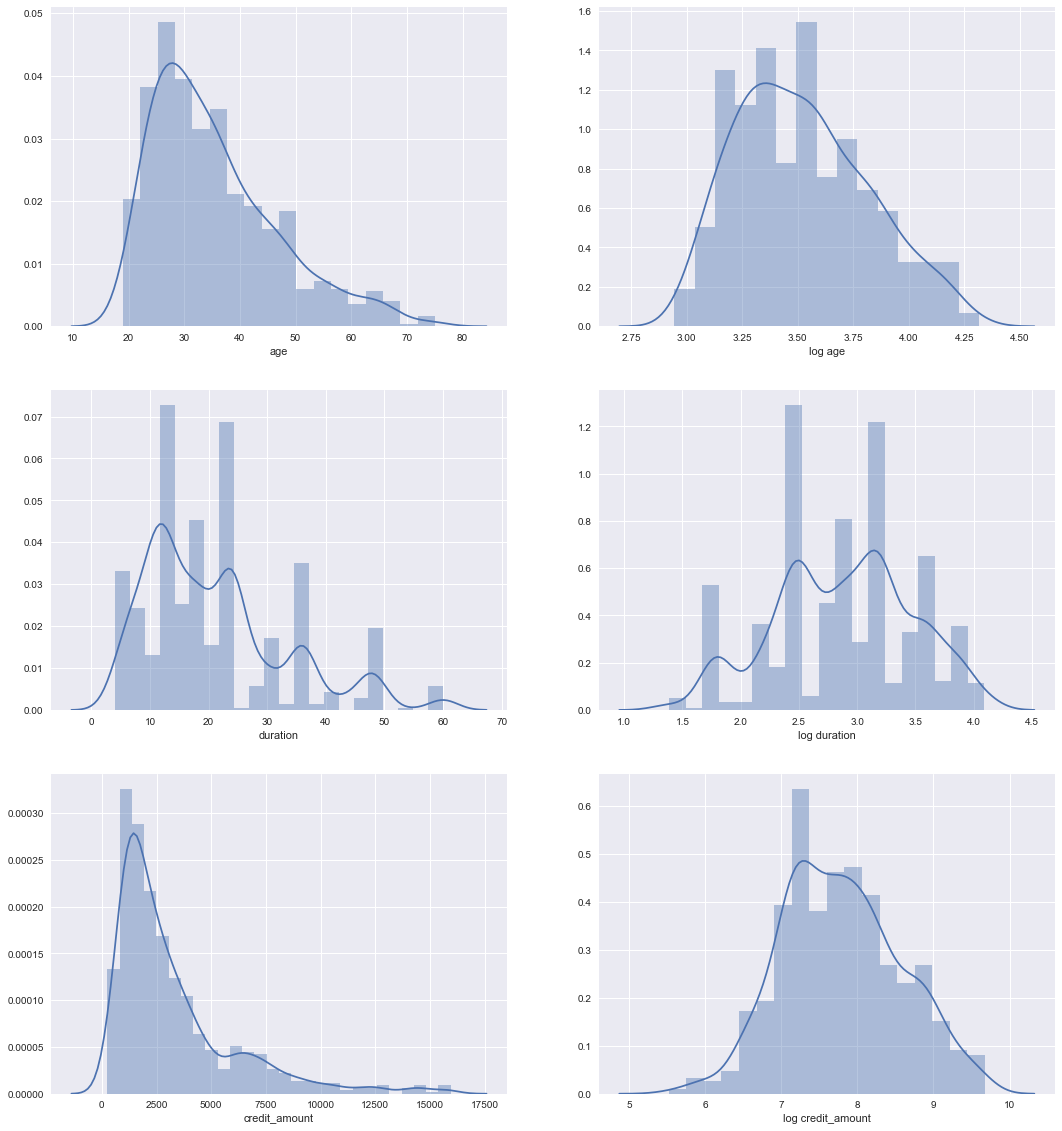

In [26]:
plt.figure(figsize=(18,20))
numericals = ['age','duration', 'credit_amount']

for i, feature in enumerate(numericals):
    ax1 = plt.subplot(3,2,2*i+1)
    sns.distplot(samp_df_train.select(feature).toPandas(), ax = ax1)
    plt.xlabel(feature)
    ax2 = plt.subplot(3,2,2*i+2)
    sns.distplot(samp_df_train.select(F.log(feature)).toPandas(), ax = ax2)
    plt.xlabel('log ' + feature)

Since the distributions of the log of the numerics are more close to a normal dist. it make sense to add them as features.
Also, first the numeric features will be used as is. After, based on the first results, maybe some of them will be categorized in order to improve performance.

Define categoricals and numericals column names lists:

In [27]:
df_train.columns

['checking_status',
 'duration',
 'credit_history',
 'purpose',
 'credit_amount',
 'savings_status',
 'employment',
 'installment_commitment',
 'personal_status',
 'other_parties',
 'residence_since',
 'property_magnitude',
 'age',
 'other_payment_plans',
 'housing',
 'existing_credits',
 'job',
 'num_dependents',
 'own_telephone',
 'foreign_worker',
 'class']

In [28]:
categorical_features = ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude',
        'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker']
numerical_features = ['duration', 'credit_amount', 'age']

In [29]:
numerical_features

['duration', 'credit_amount', 'age']

add the log of the numericals:

In [30]:
log_numericals = []
for numerical in numerical_features:
    df_train = df_train.withColumn('log_' + numerical, F.log(numerical))
    df_test = df_test.withColumn('log_' + numerical, F.log(numerical))
    log_numericals += ['log_' + numerical]
numerical_features += log_numericals
numerical_features

['duration',
 'credit_amount',
 'age',
 'log_duration',
 'log_credit_amount',
 'log_age']

In [31]:
# check that the log of the numericals added correctly:
df_train[numerical_features].limit(5).toPandas()

,duration,credit_amount,age,log_duration,log_credit_amount,log_age
0,6,931,32,1.791759,6.836259,3.465736
1,6,1449,31,1.791759,7.278629,3.433987
2,6,1050,35,1.791759,6.956545,3.555348
3,6,14555,23,1.791759,9.585690,3.135494
4,6,368,38,1.791759,5.908083,3.637586


vectorize categoricals and scale numericals of the train data:

In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, StandardScaler

# goal: get numeric dataframe in a pyspark.ml format (2 columns: label and features)
# while holding ordered names of all the features for later use (evaluating the model)

# initiate new columns names
strInd_outputs = [feature + '_ind' for feature in categorical_features]
oh_outputs = [feature + '_oh' for feature in categorical_features]
scaled_num_outputs = [feature + '_scaled' for feature in numerical_features]

# convert all the categroical features to indices
features_strIndList = []
for i,feature in enumerate(categorical_features):
    features_strIndList.append(StringIndexer(inputCol=feature, outputCol=strInd_outputs[i]))

# convert all the categorical indices columns to one hot encoding vectors
oh_encoder = OneHotEncoderEstimator(inputCols=strInd_outputs, outputCols=oh_outputs, dropLast=False)

# standard scaling of the numericals features
stdScalerList = []
for i,feature in enumerate(numerical_features):
    stdScalerList.append(VectorAssembler(inputCols=[feature], outputCol = feature + '_vec'))
    stdScalerList.append(StandardScaler(withMean=True, inputCol=feature + '_vec', outputCol=scaled_num_outputs[i]))

# assemble all the output vectors: one hot encoded categoricals and scaled numericals
vecAssembler = VectorAssembler(inputCols = oh_outputs + scaled_num_outputs, outputCol="features")

# label the class column
label_strInd = StringIndexer(inputCol='class', outputCol = 'label')

# fit all the above in a pipeline
pipe = Pipeline(stages = features_strIndList + stdScalerList + [oh_encoder,vecAssembler, label_strInd])
pipeModel = pipe.fit(df_train)

In [33]:
df_train = pipeModel.transform(df_train)
df_test = pipeModel.transform(df_test)
df_train.select(['features','class','label']).limit(5).toPandas()

,features,class,label
0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",bad,1.0
1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",good,0.0
2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",good,0.0
3,"(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",bad,1.0
4,"(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",good,0.0


In [34]:
oh_features = []
for i,feature in enumerate(categorical_features):
    oh_features += [feature + '=' + label for label in pipeModel.stages[i].labels]
features = oh_features + numerical_features
print(features)
print(len(features))

["checking_status='no checking'", "checking_status='0<=X<200'", "checking_status='<0'", "checking_status='>=200'", "credit_history='existing paid'", "credit_history='critical/other existing credit'", "credit_history='delayed previously'", "credit_history='all paid'", "credit_history='no credits/all paid'", 'purpose=radio/tv', "purpose='new car'", 'purpose=furniture/equipment', "purpose='used car'", 'purpose=business', 'purpose=education', 'purpose=repairs', "purpose='domestic appliance'", 'purpose=other', 'purpose=retraining', "savings_status='<100'", "savings_status='no known savings'", "savings_status='100<=X<500'", "savings_status='500<=X<1000'", "savings_status='>=1000'", "employment='1<=X<4'", "employment='>=7'", "employment='4<=X<7'", "employment='<1'", 'employment=unemployed', 'installment_commitment=4', 'installment_commitment=2', 'installment_commitment=3', 'installment_commitment=1', "personal_status='male single'", "personal_status='female div/dep/mar'", "personal_status='ma

In [35]:
df_train.agg(F.sum('label') / df_train.count()).collect()

[Row((sum(label) / 806)=0.29404466501240695)]

29.4% of the loans are bad - the data is naturally imbalanced (most of the pepole return the loan...) hence we can't use accuracy as performance measure (just predict all as good loans and we get accuracy of 70%...).

Under the general purpose of 80% "success" we need to refine the goal. In our case of loans, we want to detect as much as bad loans but we also want to ensure not to reject too much potenially good loans. Now if we define bad loans as the positive class (1), as we did, and good loans as negative (0) that's mean we want to maximaize recall and minimize false positive rate (FPR). Thats exactly what The ROC curve gives along with the AUC-score which give us a single number of the goodness of the ROC.

Nonetheless due to the imbalance of the data it should be noted that it is quite "easy" to get good/low FPR and even if the recall is not so high, still get good auc score. To take care of it we will also look at the f1-score which concentrates on the performance of detecting the positive class (harmonic mean of the precision and recall).

start with logistic regression with default parameters:

In [36]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()
lrModel = lr.fit(df_train)
predictions = lrModel.transform(df_test)
predictions.filter(predictions['prediction'] == 1) \
    .select("class","probability","label","prediction","rawPrediction") \
    .orderBy("probability", ascending=True) \
    .show(n = 10, truncate = 30)

+-----+------------------------------+-----+----------+------------------------------+
|class|                   probability|label|prediction|                 rawPrediction|
+-----+------------------------------+-----+----------+------------------------------+
|  bad|[0.03381508490337079,0.9661...|  1.0|       1.0|[-3.3524482375453246,3.3524...|
|  bad|[0.09115583044992029,0.9088...|  1.0|       1.0|[-2.2996031843239155,2.2996...|
|  bad|[0.0968229491075955,0.90317...|  1.0|       1.0|[-2.23303456010424,2.233034...|
|  bad|[0.11259762834837729,0.8874...|  1.0|       1.0|[-2.0644778586675465,2.0644...|
|  bad|[0.12468108666848823,0.8753...|  1.0|       1.0|[-1.948829121811411,1.94882...|
|  bad|[0.1269993882948743,0.87300...|  1.0|       1.0|[-1.9277539866613145,1.9277...|
| good|[0.14201197122650844,0.8579...|  0.0|       1.0|[-1.7986787884523028,1.7986...|
| good|[0.1820936095327871,0.81790...|  0.0|       1.0|[-1.5022270000301448,1.5022...|
|  bad|[0.18739702726953467,0.8126...|  1.0

auc of test data:

In [37]:
lrModel.evaluate(df_test).areaUnderROC

0.8137646916272873

In [38]:
# just check the type returned by evaluate():
lrModel.evaluate(df_test)

In [39]:
lrModel.evaluate(df_test).fMeasureByLabel()

[0.8458781362007167, 0.6055045871559633]

note that summary of the model is the *training* summary (in contrary to evaluate(df_test) that gives summary of the test data):

In [40]:
print(lrModel.summary.fMeasureByLabel())
print(lrModel.summary.areaUnderROC)

[0.8597816960537363, 0.6033254156769596]
0.8426175168516826


Now lets do some cross-validation with the LR parameters:

In [41]:
lr = LogisticRegression()
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.3, 1.0]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())
evaluator = BinaryClassificationEvaluator() # the default metric is roc-auc
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(df_train)

predictions = cvModel.transform(df_test)
# Evaluate best model
evaluator.evaluate(predictions)

0.7955894826123833

We get slightly worse performnce than with LR with deafult parameters. lets investigate the cv reulsts in detail:

In [42]:
param_names = [param.name for param in cvModel.getEstimatorParamMaps()[0]]
cv_results = pd.DataFrame(columns=param_names + ['score'])    
for i,(params,score) in enumerate(zip(cvModel.getEstimatorParamMaps(),cvModel.avgMetrics)):
    cv_results.loc[i] = list(params.values()) + [score]
cv_results.sort_values(by=['score'],ascending=False)    

,regParam,elasticNetParam,score
24,3.00,0.0,0.777422
20,1.00,0.0,0.777059
28,10.00,0.0,0.775948
13,0.10,0.1,0.775823
16,0.30,0.0,0.775598
10,0.03,0.3,0.770043
12,0.10,0.0,0.768726
9,0.03,0.1,0.768256
7,0.01,1.0,0.767117
6,0.01,0.3,0.765926


the results demonstrate that some regularization is needed and we should use L2 loss. lets plot the roc curve:

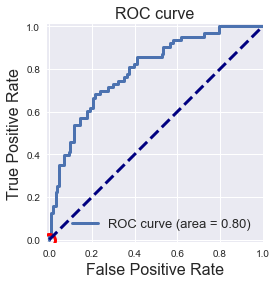

In [43]:
summary = cvModel.bestModel.evaluate(df_test)
roc = summary.roc.toPandas()
roc_auc = summary.areaUnderROC
rawPrediction = summary.predictions.select('rawPrediction').rdd.map(lambda x: x[0][1]).collect()
plot_utils_spark.plot_roc_curve(roc,roc_auc,rawPrediction)

In [44]:
utils.model_summary(cvModel.bestModel.summary, summary, cvModel.transform(df_train), predictions)

train auc score:  0.8191252697381592
train f1-score:  0.0
train precision:  0.0
train recall:  0.0
True Negatives: 569
False Positives: 0
False Negatives: 237
True Positives: 0
Total 806
test auc score:  0.7955894826123833
test f1-score:  0.0
test precision:  0.0
test recall:  0.0
True Negatives: 131
False Positives: 0
False Negatives: 63
True Positives: 0
Total 194


We can see that though the model presents good auc (0.81) there is in fact very small f1-score, mainly due to very low recall.. so this is not what we want - maximize f1 score under the constrain of auc = 0.8. lets see some of the positive predictions:

In [45]:
predictions.filter(predictions['prediction'] == 1) \
    .select("class","probability","label","prediction","rawPrediction") \
    .orderBy("probability", ascending=True) \
    .show(n = 10, truncate = 30)

+-----+-----------+-----+----------+-------------+
|class|probability|label|prediction|rawPrediction|
+-----+-----------+-----+----------+-------------+
+-----+-----------+-----+----------+-------------+



we can see that the minimum probability is 0.3 and it is gt closer to 0.5 very closely - explains the low recall. lets try to fix it. there are several way to do it:

1. choose another point on the roc curve/ select another threshold - as can be seen in the roc curve we can achieve recall of 0.4 with less than 10% of FPR.
2. Do cross-validation again with the areaUnderPR metric that is more close to the f1 score.

Lets try the PR cv:

In [46]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]) # regularization parameter
             .build())
evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(df_train)

predictions = cvModel.transform(df_test)
# Evaluate best model
evaluator.evaluate(predictions)

0.6827544778361765

the cv results:

In [47]:
param_names = [param.name for param in cvModel.getEstimatorParamMaps()[0]]
cv_results = pd.DataFrame(columns=param_names + ['score'])    
for i,(params,score) in enumerate(zip(cvModel.getEstimatorParamMaps(),cvModel.avgMetrics)):
    cv_results.loc[i] = list(params.values()) + [score]
cv_results.sort_values(by=['score'],ascending=False)    

,regParam,score
3,0.10,0.572720
2,0.03,0.571872
1,0.01,0.570308
5,1.00,0.568951
4,0.30,0.568242
0,0.00,0.564878
6,3.00,0.564783
7,10.00,0.562357


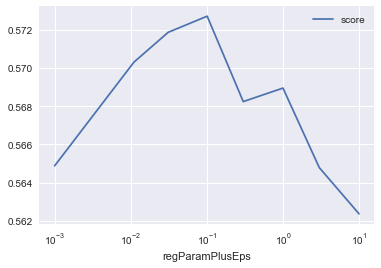

In [48]:
cv_results['regParamPlusEps'] = cv_results['regParam'] + 0.001
cv_results.plot(x='regParamPlusEps', y = 'score', logx=True)

The beahavior of the score as function of the regParam is as expected: at very low values there is overfitting and low score, mid range values are optimal and too high values cause to underfitting

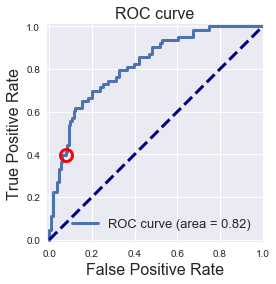

In [49]:
summary = cvModel.bestModel.evaluate(df_test)
roc = summary.roc.toPandas()
roc_auc = summary.areaUnderROC
rawPrediction = summary.predictions.select('rawPrediction').rdd.map(lambda x: x[0][1]).collect()
plot_utils_spark.plot_roc_curve(roc,roc_auc,rawPrediction)

In [50]:
summary.recallByLabel

[0.9236641221374046, 0.4126984126984127]

we can see that this roc is better and we can achieve more than 0.5 recall with only 10% of FPR (although the loss functions brings us to 0.41 recall but with change of the threshold we can improve the recall with almost no decrease in the FPR)

In [51]:
utils.model_summary(cvModel.bestModel.summary, summary, 
                    cvModel.transform(df_train), cvModel.transform(df_test))

train auc score:  0.8344308246757577
train f1-score:  0.5469168900804289
train precision:  0.75
train recall:  0.43037974683544306
True Negatives: 535
False Positives: 34
False Negatives: 135
True Positives: 102
Total 806
test auc score:  0.8189749182115598
test f1-score:  0.5252525252525252
test precision:  0.7222222222222222
test recall:  0.4126984126984127
True Negatives: 121
False Positives: 10
False Negatives: 37
True Positives: 26
Total 194


In [52]:
# the following code just to experience accessing element in a vector in a dataframe so we can look
# in a specific location of predictions dataframe, more specificly - where the threshold is (prob=0.5)
# https://stackoverflow.com/questions/44425159/access-element-of-a-vector-in-a-spark-dataframe-logistic-regression-probability
from pyspark.sql.types import FloatType
first_element = F.udf(lambda v: float(v[0]), FloatType()) # cast to float since udf supports
# only python types whie pyspark.ml Vectors automatically converts the numbers to numpy types.
# see https://issues.apache.org/jira/browse/SPARK-12157
predictions = predictions.withColumn('prob0', first_element('probability'))
predictions.filter(predictions['prob0'] > 0.48) \
    .select("class","probability","label","prediction","rawPrediction") \
    .orderBy("probability", ascending=True) \
    .show(n = 10, truncate = 30)

+-----+------------------------------+-----+----------+------------------------------+
|class|                   probability|label|prediction|                 rawPrediction|
+-----+------------------------------+-----+----------+------------------------------+
|  bad|[0.48164632388448864,0.5183...|  1.0|       1.0|[-0.07344770486351693,0.073...|
| good|[0.4824987346838203,0.51750...|  0.0|       1.0|[-0.07003367183330544,0.070...|
| good|[0.4933798215735955,0.50662...|  0.0|       1.0|[-0.026482261286999265,0.02...|
|  bad|[0.4943414982325189,0.50565...|  1.0|       1.0|[-0.022634973424418225,0.02...|
| good|[0.525222660196674,0.474777...|  0.0|       0.0|[0.1009763515164217,-0.1009...|
|  bad|[0.5338696559442749,0.46613...|  1.0|       0.0|[0.1356864158847222,-0.1356...|
|  bad|[0.5373829791266432,0.46261...|  1.0|       0.0|[0.14981147999273792,-0.149...|
| good|[0.5389820541454388,0.46101...|  0.0|       0.0|[0.1562453052938526,-0.1562...|
|  bad|[0.5403491568754973,0.45965...|  1.0

To summarize -  we got satisfing results! the test auc score is 0.82 - larger than 0.8!

Anyway, if we dig deeper we find that while the model keeps FPR rate low (10%)as needed, the recall is quite low - only 0.56, and it is reflected in test f1-score of only 0.59.

So, we can stop here and be content with the current results or the seek for better models that treat the positive class better (not on the expense of low FPR).

### feature importance/ selection:

Altough we are not in high variance situation (so we don't need to reduce the number of features) it is interesting to see which are the more important predictors:

In [53]:
# first glance at the coefs:
coef = cvModel.bestModel.coefficients.toArray()
coef

array([-0.59962979,  0.22922455,  0.51507416, -0.06571917,  0.14031337,
       -0.3603605 , -0.09757503,  0.43022918,  0.76638015, -0.17264814,
        0.35156191, -0.00319261, -0.51974464, -0.08755403,  0.60185863,
        0.0746367 ,  0.13833841, -0.15305177, -0.44167531,  0.26887734,
       -0.27427728,  0.16852523, -0.26461709, -0.5435827 ,  0.02310975,
       -0.04646977, -0.30762102,  0.29718536,  0.11496875,  0.20903227,
       -0.11530556, -0.01506547, -0.24635148, -0.17082891,  0.14553723,
       -0.02677124,  0.27964506,  0.10544122, -0.46519377,  0.32391144,
       -0.05307585,  0.11831655,  0.06098974, -0.17426555, -0.01599175,
       -0.17855595,  0.00332271,  0.29380554, -0.20480072,  0.16582266,
        0.25838686, -0.14362271,  0.18827607,  0.02152002, -0.01473668,
        0.0194428 , -0.08451243,  0.22835214,  0.0070478 ,  0.00103824,
       -0.0080016 , -0.03113152, -0.04559541,  0.04559332,  0.12170056,
       -0.12170167,  0.48401937, -0.48402639,  0.13040537,  0.14

In [54]:
# let sort them w.r.t thier abs value:
importance_idx = np.argsort(abs(coef))[::-1]
importance_idx

array([ 8, 14,  0, 23, 12,  2, 67, 66, 38, 18,  7,  5, 10, 39, 26, 27, 47,
       36, 20, 19, 22, 50, 32,  1, 57, 29, 48, 52, 45, 43,  9, 33, 21, 49,
       71, 17, 34, 51, 69,  4, 16, 68, 65, 64, 41, 30, 28, 37,  6, 13, 56,
       15, 73,  3, 42, 40, 70, 25, 62, 63, 61, 35, 24, 53, 55, 44, 31, 54,
       60, 58, 46, 11, 59, 72], dtype=int64)

In [55]:
# feature sorted by importance:
[features[idx] for idx in importance_idx]

["credit_history='no credits/all paid'",
 'purpose=education',
 "checking_status='no checking'",
 "savings_status='>=1000'",
 "purpose='used car'",
 "checking_status='<0'",
 'foreign_worker=no',
 'foreign_worker=yes',
 'other_parties=guarantor',
 'purpose=retraining',
 "credit_history='all paid'",
 "credit_history='critical/other existing credit'",
 "purpose='new car'",
 "other_parties='co applicant'",
 "employment='4<=X<7'",
 "employment='<1'",
 "property_magnitude='no known property'",
 "personal_status='male div/sep'",
 "savings_status='no known savings'",
 "savings_status='<100'",
 "savings_status='500<=X<1000'",
 'other_payment_plans=stores',
 'installment_commitment=1',
 "checking_status='0<=X<200'",
 'existing_credits=4',
 'installment_commitment=4',
 'other_payment_plans=none',
 'housing=rent',
 "property_magnitude='real estate'",
 'residence_since=1',
 'purpose=radio/tv',
 "personal_status='male single'",
 "savings_status='100<=X<500'",
 'other_payment_plans=bank',
 'log_durat

plot the most N important features:

C:\Users\Yair\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

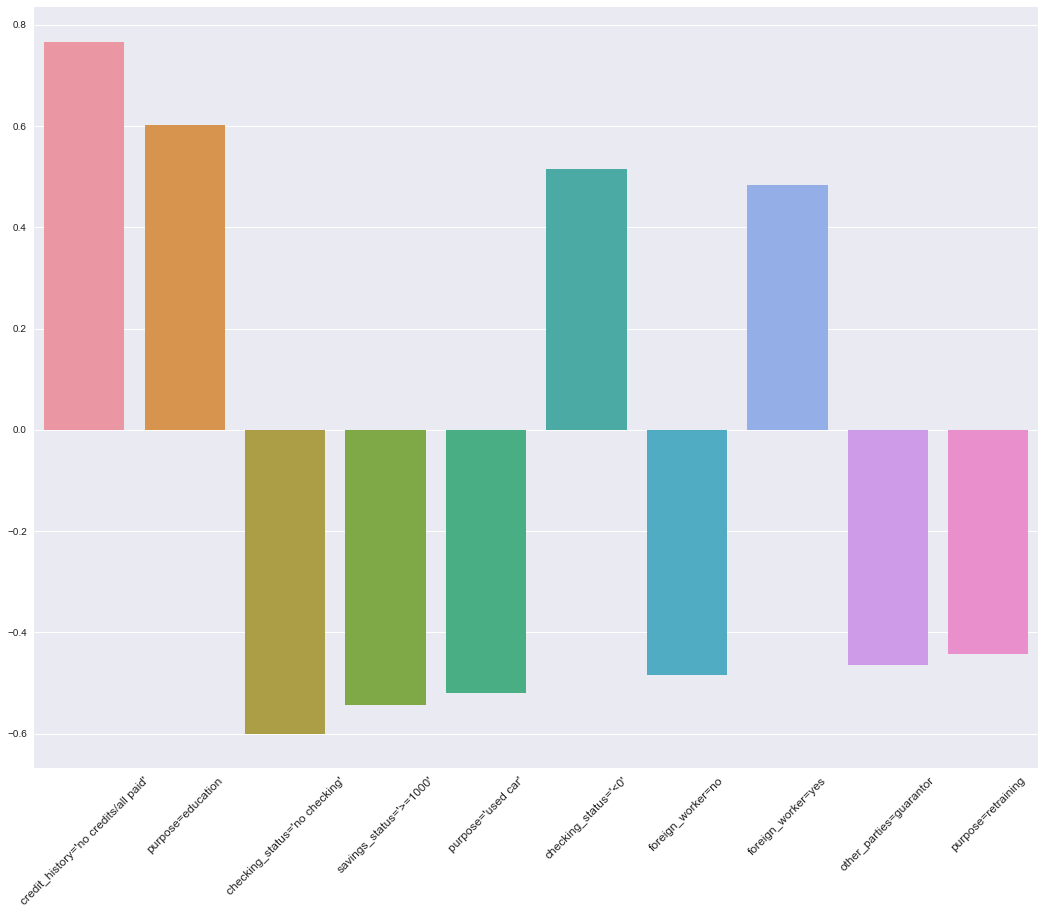

In [56]:
plt.figure(figsize=(18,14))
# ax = plt.bar(np.arange(10), model.coef_[0][importance_idx][:10],
#              tick_label = [features_names[idx] for idx in importance_idx][:10])
sns.barplot([features[idx] for idx in importance_idx][:10], coef[importance_idx][:10])
plt.xticks(rotation = 45, size = 12)

From the top 10 we can see that there aren't features with significant higher importance (the coefs value decrease slowly from the begining).

Some insights:
1. purpose=education are good predictors of bad loans. (reasonable)
2. Big amount of savings (>1000) are good predictor for good loans. (also, resonable)
3. suprisingly, no credits/all paid is good predictor for bad loans

an overall look on feature importance:

C:\Users\Yair\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


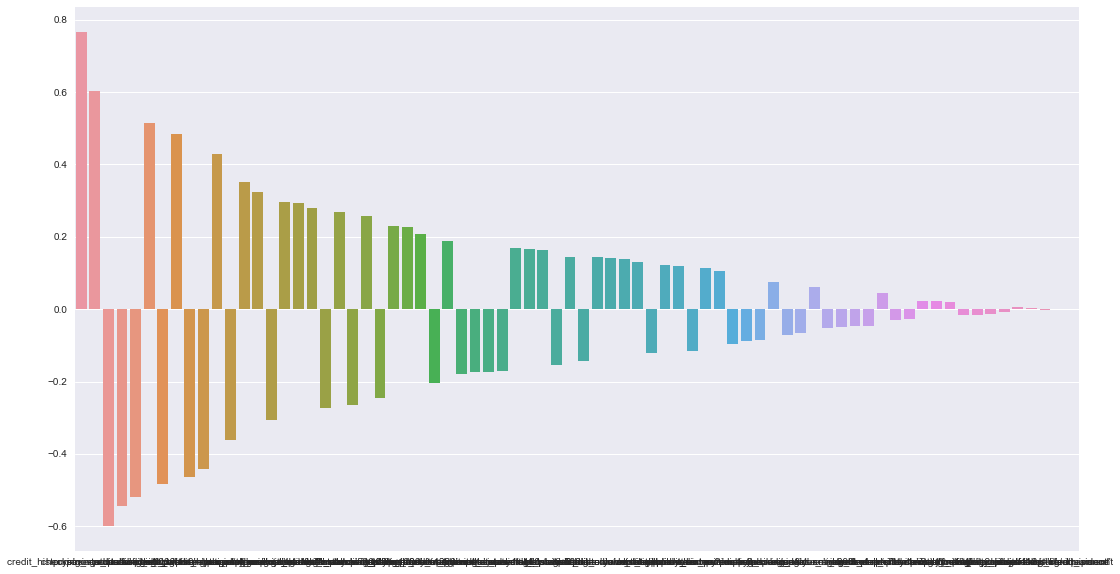

In [57]:
plt.figure(figsize=(18,10))
sns.barplot([features[idx] for idx in importance_idx], coef[importance_idx])

predictors of bad loans:

In [58]:
print([features[idx] for idx in importance_idx if coef[idx] > 0 ])

["credit_history='no credits/all paid'", 'purpose=education', "checking_status='<0'", 'foreign_worker=yes', "credit_history='all paid'", "purpose='new car'", "other_parties='co applicant'", "employment='<1'", "property_magnitude='no known property'", "personal_status='male div/sep'", "savings_status='<100'", 'other_payment_plans=stores', "checking_status='0<=X<200'", 'existing_credits=4', 'installment_commitment=4', 'housing=rent', "savings_status='100<=X<500'", 'other_payment_plans=bank', 'log_duration', "personal_status='female div/dep/mar'", 'credit_amount', "credit_history='existing paid'", "purpose='domestic appliance'", 'duration', 'own_telephone=none', 'residence_since=2', 'employment=unemployed', 'other_parties=none', 'purpose=repairs', 'residence_since=3', 'num_dependents=2', "employment='1<=X<4'", "housing='for free'", 'existing_credits=2', 'job=skilled', "property_magnitude='life insurance'", "job='unskilled resident'"]


predictors of good loans:

In [59]:
print([features[idx] for idx in importance_idx if coef[idx] < 0 ])

["checking_status='no checking'", "savings_status='>=1000'", "purpose='used car'", 'foreign_worker=no', 'other_parties=guarantor', 'purpose=retraining', "credit_history='critical/other existing credit'", "employment='4<=X<7'", "savings_status='no known savings'", "savings_status='500<=X<1000'", 'installment_commitment=1', 'other_payment_plans=none', "property_magnitude='real estate'", 'residence_since=1', 'purpose=radio/tv', "personal_status='male single'", 'purpose=other', 'housing=own', 'own_telephone=yes', 'installment_commitment=2', "credit_history='delayed previously'", 'purpose=business', 'existing_credits=3', 'log_age', "checking_status='>=200'", 'residence_since=4', 'age', "employment='>=7'", 'num_dependents=1', "job='unemp/unskilled non res'", "personal_status='male mar/wid'", 'property_magnitude=car', 'installment_commitment=3', 'existing_credits=1', "job='high qualif/self emp/mgmt'", 'purpose=furniture/equipment', 'log_credit_amount']


From inspection of the predictors above there are some which make sense ,like savings_status='>=1000' -> good loan, but not a few which not make sense, like credit_history='critical/other existing credit' -> good loan. Thats correspond with the low f1-score of the current model.

A function to inspect samples and their prediction, compared to the true value:

In [60]:
def getrows(df, rownums=None):
    return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])

def examine_predictions(sample_num):
    row = getrows(predictions, rownums=[sample_num]).collect()[0]
    for i in range(10):
        print([features[idx] for idx in importance_idx][i].ljust(50) + str(row.features[int(importance_idx[i])]))
    print()
    print('true class value: {}'.format('bad' if row.label == 1 else 'good'))
    print('predicted class value: {}'.format('bad' if row.prediction == 1 else 'good'))

In [61]:
examine_predictions(0)

credit_history='no credits/all paid'              0.0
purpose=education                                 1.0
checking_status='no checking'                     0.0
savings_status='>=1000'                           1.0
purpose='used car'                                0.0
checking_status='<0'                              0.0
foreign_worker=no                                 0.0
foreign_worker=yes                                1.0
other_parties=guarantor                           0.0
purpose=retraining                                0.0

true class value: bad
predicted class value: bad


Comparision of the features importance as obtained from the LR coefficients vs the selected features that are obtained from the ChiSqSelector:

In [62]:
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector(numTopFeatures=10, outputCol="selectedFeatures")
selector_model = selector.fit(df_train)
[features[idx] for idx in selector_model.selectedFeatures]

["checking_status='no checking'",
 "checking_status='<0'",
 "credit_history='critical/other existing credit'",
 "credit_history='no credits/all paid'",
 "savings_status='<100'",
 'duration',
 'log_duration',
 'housing=own',
 "property_magnitude='no known property'",
 "employment='<1'"]

From the comparision it seems that checking_status and credit_history are probably the most importanat features.

Lets compare the performance of using the LR 10 largest coefs vs ChiSq top-10: 

In [63]:
from pyspark.ml.linalg import DenseVector, SparseVector, VectorUDT
from functools import partial

# function to get slice of specific indices from SparseVector
def sliced_sparse_vector(v, ids):
    ids_and_values = list(zip(*[(i, v[idx]) for i, idx in enumerate(ids) if v[idx] != 0.0]))
    return SparseVector(len(ids), *ids_and_values)

# since udf cannot take arguments we need to bypass this limit.
# one way is to use parital function application.
# see: https://stackoverflow.com/questions/48443892/pyspark-using-udf-with-arguments-to-create-a-new-column

lr_most_important_idx = importance_idx[:10].tolist()
lr_sliced_sparse_vector = partial(sliced_sparse_vector, ids=lr_most_important_idx)
lr_sliced_sparse_vector = F.udf(lr_sliced_sparse_vector, VectorUDT())

chiSq_sliced_sparse_vector = partial(sliced_sparse_vector, ids=selector_model.selectedFeatures)
chiSq_sliced_sparse_vector = F.udf(chiSq_sliced_sparse_vector, VectorUDT())


In [64]:
from pyspark.sql.types import ArrayType
# another related SparseVector transformations:

def sparse_to_array(v):
    v = DenseVector(v)
    new_array = list([float(x) for x in v])
    return new_array

sparse_to_array_udf = F.udf(sparse_to_array, ArrayType(FloatType()))
a = SparseVector(4, [0, 1], [3., -4.])
print(sparse_to_array(a))
print(sliced_sparse_vector(a, [1,2]))

def add_empty_col_(v):
    return SparseVector(v.size + 1, v.indices, v.values)

add_empty_col = F.udf(add_empty_col_, VectorUDT())
df_train.select(add_empty_col("features")).show()

[3.0, -4.0, 0.0, 0.0]
(2,[0],[-4.0])
+------------------------+
|add_empty_col_(features)|
+------------------------+
|    (75,[1,7,10,21,27...|
|    (75,[1,6,13,21,25...|
|    (75,[1,6,11,19,28...|
|    (75,[1,4,10,20,28...|
|    (75,[1,4,9,20,25,...|
|    (75,[1,4,9,19,26,...|
|    (75,[1,4,9,19,27,...|
|    (75,[1,4,9,19,24,...|
|    (75,[1,4,9,19,25,...|
|    (75,[1,4,9,19,27,...|
|    (75,[1,4,9,19,27,...|
|    (75,[1,4,9,19,24,...|
|    (75,[1,4,13,19,27...|
|    (75,[1,4,11,19,24...|
|    (75,[1,4,9,19,26,...|
|    (75,[1,4,9,19,24,...|
|    (75,[1,7,10,21,26...|
|    (75,[1,7,12,19,25...|
|    (75,[1,5,14,23,25...|
|    (75,[1,5,14,19,25...|
+------------------------+
only showing top 20 rows



In [65]:

# add the 2 sliced vectors as columns to df_train and df_test and fit LR model:
df_train = df_train.withColumn('lr_sliced_features',lr_sliced_sparse_vector('features')) \
                   .withColumn('chiSq_sliced_features',chiSq_sliced_sparse_vector('features'))
df_test = df_test.withColumn('lr_sliced_features',lr_sliced_sparse_vector('features')) \
                   .withColumn('chiSq_sliced_features',chiSq_sliced_sparse_vector('features'))

lr = LogisticRegression(featuresCol='lr_sliced_features')
lrModel = lr.fit(df_train)

chiSq = LogisticRegression(featuresCol='chiSq_sliced_features')
chiSqModel = chiSq.fit(df_train)

lr_summary = lrModel.evaluate(df_test)
chiSq_summary = chiSqModel.evaluate(df_test)

print('LR auc:', lr_summary.areaUnderROC)
print('chiSq auc:', chiSq_summary.areaUnderROC)
print('LR f1:', lr_summary.fMeasureByLabel()[1])
print('chiSq f1:', chiSq_summary.fMeasureByLabel()[1])

LR auc: 0.707197382769902
chiSq auc: 0.7721434629831577
LR f1: 0.5172413793103449
chiSq f1: 0.5192307692307693


In [66]:
print('Detailed LR results with top-10 largest coefs features:')
utils.model_summary(lrModel.summary, lr_summary, 
                    lrModel.transform(df_train), lrModel.transform(df_test))

Detailed LR results with top-10 largest coefs features:
train auc score:  0.7557636834182407
train f1-score:  0.5023255813953488
train precision:  0.5595854922279793
train recall:  0.45569620253164556
True Negatives: 484
False Positives: 85
False Negatives: 129
True Positives: 108
Total 806
test auc score:  0.707197382769902
test f1-score:  0.5172413793103449
test precision:  0.5660377358490566
test recall:  0.47619047619047616
True Negatives: 108
False Positives: 23
False Negatives: 33
True Positives: 30
Total 194


In [67]:
print('Detailed ChiSq results with top-10 largest coefs features:')
utils.model_summary(chiSqModel.summary, chiSq_summary, 
                    chiSqModel.transform(df_train), chiSqModel.transform(df_test))

Detailed ChiSq results with top-10 largest coefs features:
train auc score:  0.7808910443223362
train f1-score:  0.4923857868020305
train precision:  0.6178343949044586
train recall:  0.4092827004219409
True Negatives: 509
False Positives: 60
False Negatives: 140
True Positives: 97
Total 806
test auc score:  0.7721434629831577
test f1-score:  0.5192307692307693
test precision:  0.6585365853658537
test recall:  0.42857142857142855
True Negatives: 117
False Positives: 14
False Negatives: 36
True Positives: 27
Total 194


So it seems that chiSq is more accurate in predicting to most important features than the abolute values of the LR coef. with only 10 features we got only minor decrease (~0.05) in the auc.

Indeed, using only those 49 features are enough to get the same results as with all the 64.

## Tries to improve results

let add another feature: The credit amount-duration ratio:

In [68]:
df_train = df_train.withColumn('credit_duration_ratio', df_train.credit_amount / df_train.duration)
df_test = df_test.withColumn('credit_duration_ratio', df_test.credit_amount / df_test.duration)
df_train.select('credit_duration_ratio').show(5)

+---------------------+
|credit_duration_ratio|
+---------------------+
|   155.16666666666666|
|                241.5|
|                175.0|
|   2425.8333333333335|
|   61.333333333333336|
+---------------------+
only showing top 5 rows



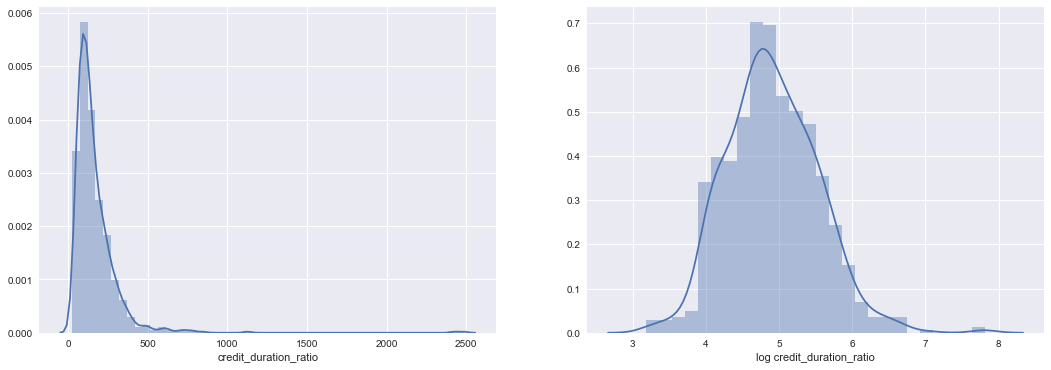

In [69]:
samp_df_train = sample_df(df_train)

plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
sns.distplot(samp_df_train.select('credit_duration_ratio').toPandas(), ax = ax1)
plt.xlabel('credit_duration_ratio')
ax2 = plt.subplot(1,2,2)
sns.distplot(samp_df_train.select(F.log('credit_duration_ratio')).toPandas(), ax = ax2)
plt.xlabel('log ' + 'credit_duration_ratio')

From the graph it seems that the log of the principal may be a good/ better feature. need to add it:

In [70]:
df_train = df_train.withColumn('log_credit_duration_ratio',
                               F.log('credit_duration_ratio'))
df_test = df_test.withColumn('log_credit_duration_ratio',
                               F.log('credit_duration_ratio'))
df_train.select('log_credit_duration_ratio').show(5)

+-------------------------+
|log_credit_duration_ratio|
+-------------------------+
|        5.044499808049012|
|        5.486869473092628|
|       5.1647859739235145|
|       7.7939303869516685|
|        4.116323468940876|
+-------------------------+
only showing top 5 rows



In [71]:
# initiate new columns names

vecAssembler1 = VectorAssembler(inputCols = ['credit_duration_ratio', 'log_credit_duration_ratio'],
                               outputCol="temp1")
stdScaler = StandardScaler(withMean=True, inputCol='temp1', outputCol='temp2')

vecAssembler2 = VectorAssembler(inputCols = ['features','temp2'], outputCol="features1")

# fit all the above in a pipeline
pipe = Pipeline(stages = [vecAssembler1, stdScaler, vecAssembler2])
pipeModel = pipe.fit(df_train)

In [72]:
df_train = pipeModel.transform(df_train)
df_test = pipeModel.transform(df_test)
df_train = df_train.drop('temp1','temp2','features').withColumnRenamed('features1','features')
df_test = df_test.drop('temp1','temp2','features').withColumnRenamed('features1','features')
df_train.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|(76,[1,7,10,21,27...|
|(76,[1,6,13,21,25...|
|(76,[1,6,11,19,28...|
|(76,[1,4,10,20,28...|
|(76,[1,4,9,20,25,...|
+--------------------+
only showing top 5 rows



In [73]:
numerical_features = numerical_features + ['credit_duration_ratio', 'log_credit_duration_ratio']
features += ['credit_duration_ratio', 'log_credit_duration_ratio']
numerical_features

['duration',
 'credit_amount',
 'age',
 'log_duration',
 'log_credit_amount',
 'log_age',
 'credit_duration_ratio',
 'log_credit_duration_ratio']

let's check if it does something to the results:

In [74]:
lr = LogisticRegression()
lrModel = lr.fit(df_train)

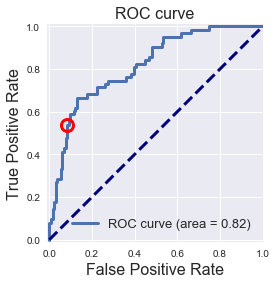

train auc score:  0.8461176243761727
train f1-score:  0.6232558139534883
train precision:  0.694300518134715
train recall:  0.5654008438818565
True Negatives: 510
False Positives: 59
False Negatives: 103
True Positives: 134
Total 806
test auc score:  0.8188537501514606
test f1-score:  0.6238532110091742
test precision:  0.7391304347826086
test recall:  0.5396825396825397
True Negatives: 119
False Positives: 12
False Negatives: 29
True Positives: 34
Total 194


In [75]:
summary = lrModel.evaluate(df_test)
roc = summary.roc.toPandas()
roc_auc = summary.areaUnderROC
rawPrediction = summary.predictions.select('rawPrediction').rdd.map(lambda x: x[0][1]).collect()
plot_utils_spark.plot_roc_curve(roc,roc_auc,rawPrediction)
utils.model_summary(lrModel.summary, summary, 
                    lrModel.transform(df_train), lrModel.transform(df_test))

Nice. The new 2 features add some little improvement to the results. Let's validate it:

In [76]:
selector = ChiSqSelector(numTopFeatures=60, outputCol="selectedFeatures")
selector_model = selector.fit(df_train)
[features[idx] for idx in selector_model.selectedFeatures]

["checking_status='no checking'",
 "checking_status='<0'",
 "credit_history='critical/other existing credit'",
 "credit_history='no credits/all paid'",
 "savings_status='<100'",
 'duration',
 'log_duration',
 'housing=own',
 "property_magnitude='no known property'",
 "employment='<1'",
 "property_magnitude='real estate'",
 "checking_status='0<=X<200'",
 'purpose=radio/tv',
 "savings_status='no known savings'",
 "credit_history='all paid'",
 "savings_status='>=1000'",
 'foreign_worker=yes',
 'foreign_worker=no',
 'purpose=education',
 "purpose='used car'",
 "purpose='new car'",
 "housing='for free'",
 "employment='4<=X<7'",
 'housing=rent',
 'other_payment_plans=none',
 "personal_status='female div/dep/mar'",
 "savings_status='500<=X<1000'",
 'installment_commitment=4',
 "personal_status='male single'",
 'other_parties=guarantor',
 "employment='>=7'",
 'other_payment_plans=bank',
 "other_parties='co applicant'",
 'existing_credits=1',
 "credit_history='existing paid'",
 'other_payment_p

Surprisingly the chiSqSelector score the new features quite low (~50 from 76). let see what is the absulute value of their coef:

In [77]:
importance_idx = np.argsort(abs(lrModel.coefficients.toArray()))[::-1]
[features[idx] for idx in importance_idx[:10]]

["savings_status='>=1000'",
 'purpose=retraining',
 "credit_history='no credits/all paid'",
 'foreign_worker=no',
 'purpose=education',
 'other_parties=guarantor',
 "checking_status='no checking'",
 "purpose='used car'",
 'log_credit_duration_ratio',
 'credit_duration_ratio']

Indeed, according to the coefs values the credit-duration-ratio and the log of it are the 10th and 9th most important features

## Summary

Linear regression with no regularization and default features seems to get the desired results with 83% success to predict the quality of the loan, or more precisely the model has probability of 0.83 to rank a randomly chosen positive example (bad loan) above a randomly chosen negative one (good loan).

While the results are good there is more to do in order to improve recall and precision of predicting bad loans.

## Try non-linear classifier:

In [72]:
model_svc = SVC(class_weight='balanced', random_state=42)
model_svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

train auc score:  0.848261937811
train f1-score:  0.663194444444
             precision    recall  f1-score   support

          0       0.89      0.74      0.81       559
          1       0.57      0.79      0.66       241

avg / total       0.80      0.76      0.77       800

[[415 144]
 [ 50 191]]
test auc score:  0.820771727371
test f1-score:  0.63309352518
             precision    recall  f1-score   support

          0       0.88      0.74      0.80       141
          1       0.55      0.75      0.63        59

avg / total       0.78      0.74      0.75       200

[[105  36]
 [ 15  44]]


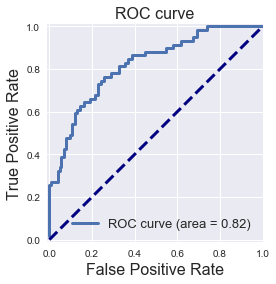

In [73]:
# Predict
pred_train = model_svc.predict(X_train)
pred_test = model_svc.predict(X_test)

y_train_score = model_svc.decision_function(X_train)
print('train auc score: ', roc_auc_score(y_train, y_train_score))
print('train f1-score: ', f1_score(y_train, pred_train))
print(classification_report(y_train, pred_train))
print(confusion_matrix(y_train, pred_train))

y_test_score = model_svc.decision_function(X_test)
print('test auc score: ', roc_auc_score(y_test, y_test_score))
print('test f1-score: ', f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

plot_utils.plot_roc_curve(model_svc, X_test, y_test)

With non-linear classifier, svc with rbf kernel, we achieved same auc score as lr. However, the svc threshold lie in different point on the roc curve with higher recall on the expense on undesirable FPR of 0.26.

Anyway this is only a prilaminary results there is a need to do hyper-parameter tuning and maybe check for other algorithms.

## Random Forest

In [74]:
model_rf = RandomForestClassifier(class_weight='balanced', n_estimators=12, max_depth=4, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

train auc score:  0.857310401651
train f1-score:  0.673952641166
             precision    recall  f1-score   support

          0       0.89      0.78      0.83       559
          1       0.60      0.77      0.67       241

avg / total       0.80      0.78      0.78       800

[[436 123]
 [ 56 185]]
test auc score:  0.746003125376
test f1-score:  0.569230769231
             precision    recall  f1-score   support

          0       0.83      0.76      0.79       141
          1       0.52      0.63      0.57        59

avg / total       0.74      0.72      0.73       200

[[107  34]
 [ 22  37]]


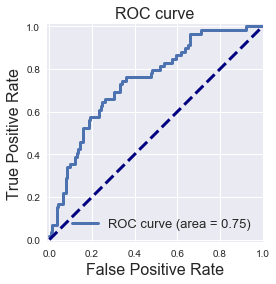

In [75]:
# Predict
pred_train = model_rf.predict(X_train)
pred_test = model_rf.predict(X_test)

y_train_score = model_rf.predict_proba(X_train)[:,1]
print('train auc score: ', roc_auc_score(y_train, y_train_score))
print('train f1-score: ', f1_score(y_train, pred_train))
print(classification_report(y_train, pred_train))
print(confusion_matrix(y_train, pred_train))

y_test_score = model_rf.predict_proba(X_test)[:,1]
print('test auc score: ', roc_auc_score(y_test, y_test_score))
print('test f1-score: ', f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

plot_utils.plot_roc_curve(model_rf, X_test, y_test)

random forest with arbitrary parameters gives over-fitted model. Lets try tuning hyper parameters with cross-validated grid search. To prevent data leakage we need to do different pre-processing for each fold. For that we will use customized class (more about using customized class and its benefit and importance while using pipline and grid-search cv you can find [in this link](https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/).

In [76]:
# a cusotm transformer class wich enables transform, pre and/or post-processing on part of the data 
# good to use in FeatureUnion class
class DfFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, trf = None, to_dict = False, sparse = False, to_array = False):
#         print("in init")
#         print(trf)
        self.cols = cols
        self.trf = trf
        self.to_dict = to_dict
        self.sparse = sparse
        self.to_array = to_array
        
    def df_pre_process(self, df):
        if self.cols is not None:
            df = df[self.cols]
        if self.to_dict:
            df = df.to_dict('records')
        return df
    
    def df_post_process(self, U):
        if self.sparse:
            U = coo_matrix(U)
        if self.to_array:
            U = U.toarray()
        return U
    
    def transform(self, df):
        X = self.df_pre_process(df)
        U = self.trf.transform(X) if self.trf is not None else X
        U = self.df_post_process(U)
        return U
    
    def fit_transform(self, df, y=None):
        X = self.df_pre_process(df)
        U = self.trf.fit_transform(X) if self.trf is not None else X       
        U = self.df_post_process(U)
        return U

hyper-parameter optimization for random forest:

In [77]:
# FeatureUnion is used to concatenate different features. We must use it because we want GridSearchCV to do it seperately 
# for each fold to prevent data leakage (until now we did it to the entire train data). Since each transformer does not applied
# to all the data we need the customized class, DFfeaures, that enables choosing only part of the data for each transformer.
f_union = (FeatureUnion([('cat_to_vect', DfFeatures(cols = categorical_features, trf = DictVectorizer(sparse = False), to_dict = True)),
                        ('scale_numericals',DfFeatures(cols = numerical_features, trf = StandardScaler())),
                        ('ohe', DfFeatures(cols = int_features, trf = OneHotEncoder(sparse = False)))]))
estimators = [('f_union', f_union), ('rnd_forest', RandomForestClassifier(class_weight='balanced', random_state=42))]
pipe = Pipeline(estimators)
param_grid = dict(rnd_forest__max_depth = [2, 3 ,4, 5, 6], rnd_forest__n_estimators = [5, 7, 10, 12, 15, 18])
clf = GridSearchCV(pipe, param_grid=param_grid, verbose = 1, scoring= 'roc_auc', return_train_score = True)
clf.fit(df_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('f_union', FeatureUnion(n_jobs=1,
       transformer_list=[('cat_to_vect', DfFeatures(cols=['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'for...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rnd_forest__max_depth': [2, 3, 4, 5, 6], 'rnd_forest__n_estimators': [5, 7, 10, 12, 15, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [78]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_rnd_forest__max_depth,param_rnd_forest__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.024653,0.010659,0.730603,0.766076,2,5,"{'rnd_forest__max_depth': 2, 'rnd_forest__n_es...",25,0.703473,0.767347,0.743347,0.776564,0.745195,0.754317,0.000942,4.703071e-04,0.019271,0.009127
1,0.025317,0.008682,0.739628,0.778935,2,7,"{'rnd_forest__max_depth': 2, 'rnd_forest__n_es...",18,0.707665,0.772421,0.752319,0.790976,0.759140,0.773408,0.000469,2.586872e-03,0.022856,0.008524
2,0.031859,0.010661,0.740697,0.793651,2,10,"{'rnd_forest__max_depth': 2, 'rnd_forest__n_es...",17,0.698950,0.791633,0.771203,0.806463,0.752251,0.782858,0.004145,4.713279e-04,0.030621,0.009741
3,0.031309,0.010333,0.732739,0.794702,2,12,"{'rnd_forest__max_depth': 2, 'rnd_forest__n_es...",22,0.699809,0.797723,0.755108,0.805372,0.743548,0.781010,0.000474,4.792378e-04,0.023843,0.010173
4,0.034569,0.010994,0.734571,0.801207,2,15,"{'rnd_forest__max_depth': 2, 'rnd_forest__n_es...",20,0.699941,0.796623,0.755679,0.811242,0.748353,0.795755,0.001581,4.052337e-07,0.024760,0.007105
5,0.040321,0.008692,0.742848,0.803569,2,18,"{'rnd_forest__max_depth': 2, 'rnd_forest__n_es...",13,0.713310,0.802403,0.763138,0.810392,0.752319,0.797912,0.005445,3.258402e-03,0.021424,0.005162
6,0.024322,0.010328,0.723615,0.811877,3,5,"{'rnd_forest__max_depth': 3, 'rnd_forest__n_es...",29,0.718030,0.804629,0.711895,0.819260,0.740961,0.811741,0.000474,4.703588e-04,0.012497,0.005974
7,0.021839,0.011875,0.725923,0.830288,3,7,"{'rnd_forest__max_depth': 3, 'rnd_forest__n_es...",27,0.703077,0.811979,0.715995,0.842189,0.758871,0.836694,0.005174,2.660028e-03,0.023845,0.013139
8,0.028981,0.010327,0.731761,0.843022,3,10,"{'rnd_forest__max_depth': 3, 'rnd_forest__n_es...",24,0.691721,0.835845,0.752789,0.849766,0.751075,0.843455,0.000004,4.710332e-04,0.028428,0.005691
9,0.031108,0.008035,0.733103,0.846168,3,12,"{'rnd_forest__max_depth': 3, 'rnd_forest__n_es...",21,0.697993,0.842918,0.756149,0.851506,0.745430,0.844079,0.000654,4.196652e-03,0.025300,0.003804


Grid best parameter (max. roc_auc):  {'rnd_forest__max_depth': 6, 'rnd_forest__n_estimators': 18}
Grid best score (roc_auc):  0.757971412549
             precision    recall  f1-score   support

          0       0.80      0.87      0.83       141
          1       0.60      0.49      0.54        59

avg / total       0.74      0.76      0.75       200



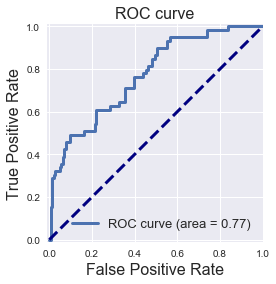

In [79]:
print('Grid best parameter (max. roc_auc): ', clf.best_params_)
print('Grid best score (roc_auc): ', clf.best_score_)
print(classification_report(y_test,clf.predict(df_test)))
plot_utils.plot_roc_curve(clf, df_test, y_test)

The hyper-parameter optimization helped elliminate the over-fitting but the results are still worse than Logistic regression. Notice that scaling was used on the numericals. Since random forest does not need scaling lets try it without it:

In [80]:
f_union = (FeatureUnion([('cat_to_vect', DfFeatures(cols = categorical_features, trf = DictVectorizer(sparse = False), to_dict = True)),
                        ('numericals',DfFeatures(cols = numerical_features + int_features))]))
estimators = [('f_union', f_union), ('rnd_forest', RandomForestClassifier(class_weight='balanced', random_state=42))]
pipe = Pipeline(estimators)
param_grid = dict(rnd_forest__max_depth = [2, 3 ,4, 5, 6], rnd_forest__n_estimators = [5, 7, 10, 12, 15, 18])
clf = GridSearchCV(pipe, param_grid=param_grid, verbose = 1, scoring= 'roc_auc', return_train_score = True)
clf.fit(df_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('f_union', FeatureUnion(n_jobs=1,
       transformer_list=[('cat_to_vect', DfFeatures(cols=['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'for...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rnd_forest__max_depth': [2, 3, 4, 5, 6], 'rnd_forest__n_estimators': [5, 7, 10, 12, 15, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

Grid best parameter (max. roc_auc):  {'rnd_forest__max_depth': 5, 'rnd_forest__n_estimators': 18}
Grid best score (roc_auc):  0.768681657924
             precision    recall  f1-score   support

          0       0.84      0.80      0.82       141
          1       0.58      0.64      0.61        59

avg / total       0.76      0.76      0.76       200



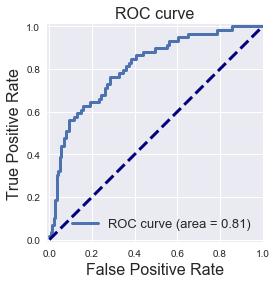

In [81]:
print('Grid best parameter (max. roc_auc): ', clf.best_params_)
print('Grid best score (roc_auc): ', clf.best_score_)
print(classification_report(y_test,clf.predict(df_test)))
plot_utils.plot_roc_curve(clf, df_test, y_test)

A better test result but the train cv results is the same so we cannot conclude nothing. Lets try grid search on svc:

In [82]:
f_union = (FeatureUnion([('cat_to_vect', DfFeatures(cols = categorical_features, trf = DictVectorizer(sparse = False), to_dict = True)),
                        ('scale_numericals',DfFeatures(cols = numerical_features, trf = StandardScaler())),
                        ('ohe', DfFeatures(cols = int_features, trf = OneHotEncoder(sparse = False)))]))
estimators = [('f_union', f_union), ('svc', SVC(class_weight='balanced', random_state=42))]
pipe = Pipeline(estimators)
param_grid = dict(svc__C = [0.01 , 0.03, 0.1, 0.3, 1, 3, 10, 30], svc__gamma = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1])
clf = GridSearchCV(pipe, param_grid=param_grid, verbose = 1, scoring= 'roc_auc', return_train_score = True)
clf.fit(df_train, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:   17.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('f_union', FeatureUnion(n_jobs=1,
       transformer_list=[('cat_to_vect', DfFeatures(cols=['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'for...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svc__C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30], 'svc__gamma': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

Grid best parameter (max. roc_auc):  {'svc__C': 1, 'svc__gamma': 0.01}
Grid best score (roc_auc):  0.775879699676
             precision    recall  f1-score   support

          0       0.88      0.70      0.78       141
          1       0.52      0.76      0.62        59

avg / total       0.77      0.72      0.73       200



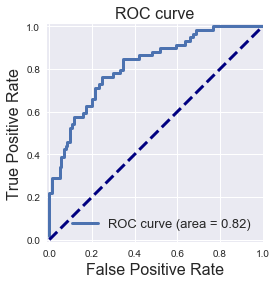

In [83]:
print('Grid best parameter (max. roc_auc): ', clf.best_params_)
print('Grid best score (roc_auc): ', clf.best_score_)
print(classification_report(y_test,clf.predict(df_test)))
plot_utils.plot_roc_curve(clf, df_test, y_test)

Interestingly the deafult parameters are the best one... C = 1 and gamma = 0.01 ~= 1/n_feauters (the auto defualt number) and the result is the same. However notice that the train score is lower than the case we use all the train data. This is reasonable due the small amount of data -> the model is trained only on 66% of the data each time...

Let's check naive Bayes. first, only on the categoricals:

In [84]:
print(X_train[:10,-8])
print(X_train[:10,-9])

[ 3.29708155 -0.00805096 -1.27925578 -0.00805096 -0.77077385  0.24619
 -1.27925578  0.24619     0.24619    -0.26229193]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [85]:
model_nb = BernoulliNB()
X_train_cat = X_train[:,:-8]
model_nb.fit(X_train_cat, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

train auc score:  0.795522532085
train f1-score:  0.583162217659
             precision    recall  f1-score   support

          0       0.82      0.81      0.82       559
          1       0.58      0.59      0.58       241

avg / total       0.75      0.75      0.75       800

[[455 104]
 [ 99 142]]
test auc score:  0.800336578916
test f1-score:  0.610687022901
             precision    recall  f1-score   support

          0       0.85      0.77      0.81       141
          1       0.56      0.68      0.61        59

avg / total       0.76      0.74      0.75       200

[[109  32]
 [ 19  40]]


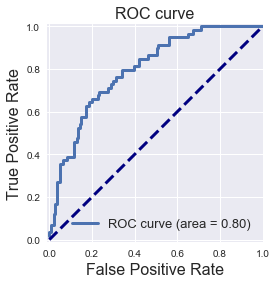

In [86]:
# Predict
X_test_cat = X_test[:,:-8]
pred_train = model_nb.predict(X_train_cat)
pred_test = model_nb.predict(X_test_cat)

y_train_score_nb = model_nb.predict_proba(X_train_cat)
print('train auc score: ', roc_auc_score(y_train, y_train_score_nb[:,1]))
print('train f1-score: ', f1_score(y_train, pred_train))
print(classification_report(y_train, pred_train))
print(confusion_matrix(y_train, pred_train))

y_test_score_nb = model_nb.predict_proba(X_test_cat)
print('test auc score: ', roc_auc_score(y_test, y_test_score_nb[:,1]))
print('test f1-score: ', f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

plot_utils.plot_roc_curve(model_nb, X_test_cat, y_test)

Not bad with NB only with the categoricals. Now, only the numericals:

In [87]:
model_gnb = GaussianNB()
X_train_num = X_train[:,-8:]
model_gnb.fit(X_train_num, y_train)

GaussianNB(priors=None)

train auc score:  0.665125186499
train f1-score:  0.373401534527
             precision    recall  f1-score   support

          0       0.74      0.86      0.80       559
          1       0.49      0.30      0.37       241

avg / total       0.66      0.69      0.67       800

[[482  77]
 [168  73]]
test auc score:  0.602957086188
test f1-score:  0.263736263736
             precision    recall  f1-score   support

          0       0.72      0.86      0.78       141
          1       0.38      0.20      0.26        59

avg / total       0.62      0.67      0.63       200

[[121  20]
 [ 47  12]]


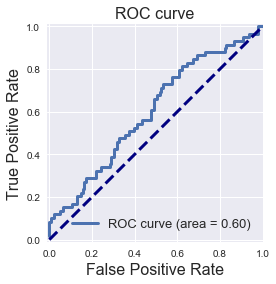

In [88]:
# Predict
X_test_num = X_test[:,-8:]
pred_train = model_gnb.predict(X_train_num)
pred_test = model_gnb.predict(X_test_num)

y_train_score_gnb = model_gnb.predict_proba(X_train_num)
print('train auc score: ', roc_auc_score(y_train, y_train_score_gnb[:,1]))
print('train f1-score: ', f1_score(y_train, pred_train))
print(classification_report(y_train, pred_train))
print(confusion_matrix(y_train, pred_train))

y_test_score_gnb = model_gnb.predict_proba(X_test_num)
print('test auc score: ', roc_auc_score(y_test, y_test_score_gnb[:,1]))
print('test f1-score: ', f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

plot_utils.plot_roc_curve(model_gnb, X_test_num, y_test)

As expected - very bad results. The categoricals are much better predictors than the numericals. Lets try to combine the results for the categoricals and the numericals (maybe there will be sinergetic effect). First we will use a soft voting based on the predicted probabilities of each classifier - we will choose the class that have the higher sum of probabilities:

In [89]:
train_prob_sum = y_train_score_nb + y_train_score_gnb
pred_train = np.argmax(train_prob_sum,axis = 1)
print('train auc score: ', roc_auc_score(y_train, train_prob_sum[:,1]/2))
print('train f1-score: ', f1_score(y_train, pred_train))
print(classification_report(y_train, pred_train))
print(confusion_matrix(y_train, pred_train))

test_prob_sum = y_test_score_nb + y_test_score_gnb
pred_test = np.argmax(test_prob_sum,axis = 1)
print('test auc score: ', roc_auc_score(y_test, test_prob_sum[:,1]/2))
print('test f1-score: ', f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

train auc score:  0.798692092429
train f1-score:  0.531764705882
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       559
          1       0.61      0.47      0.53       241

avg / total       0.74      0.75      0.74       800

[[488  71]
 [128 113]]
test auc score:  0.751893256401
test f1-score:  0.484848484848
             precision    recall  f1-score   support

          0       0.78      0.89      0.83       141
          1       0.60      0.41      0.48        59

avg / total       0.73      0.74      0.73       200

[[125  16]
 [ 35  24]]


No. Worse results than only with categoricals. Lets try to add weights to the probabilities: the weight will be higher as the probability is closer to 0 or 1 (meaning the model is more confident with its decision):

In [90]:
w_cat_train = np.abs(y_train_score_nb[:,1] - 0.5)
w_num_train = np.abs(y_train_score_gnb[:,1] - 0.5)
sum_w_train = w_cat_train + w_num_train
w_train_probs = (w_cat_train * y_train_score_nb[:,1] + w_num_train * y_train_score_gnb[:,1]) / sum_w_train
pred_train = w_train_probs > 0.5

print('train auc score: ', roc_auc_score(y_train, w_train_probs))
print('train f1-score: ', f1_score(y_train, pred_train))
print(classification_report(y_train, pred_train))
print(confusion_matrix(y_train, pred_train))

train auc score:  0.793533206155
train f1-score:  0.531764705882
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       559
          1       0.61      0.47      0.53       241

avg / total       0.74      0.75      0.74       800

[[488  71]
 [128 113]]


No improvement in train data -> there's no point in trying with test data 

2 of the categoricals are in fact ordinal:  saving status and employment. lets see their unique values:

In [91]:
print(df_train['savings_status'].unique())
print(df_train['employment'].unique())

["'<100'" "'500<=X<1000'" "'no known savings'" "'100<=X<500'" "'>=1000'"]
["'>=7'" "'<1'" "'1<=X<4'" "'4<=X<7'" 'unemployed']


So lets add numerical integer features so maybe the random forest classifier will take advantage of them:

In [92]:
savings_dict = dict([("'no known savings'",0),("'<100'",50),("'100<=X<500'",300),("'500<=X<1000'",750),("'>=1000'",1000)])
employment_dict = dict([('unemployed',0),("'<1'",1),("'1<=X<4'",2.5),("'4<=X<7'",5.5),("'>=7'",7)])
df_train['savings_status_ord'] = df_train['savings_status'].apply(lambda x: savings_dict[x])
df_train['employment_ord'] = df_train['employment'].apply(lambda x: employment_dict[x])
df_test['savings_status_ord'] = df_test['savings_status'].apply(lambda x: savings_dict[x])
df_test['employment_ord'] = df_test['employment'].apply(lambda x: employment_dict[x])
ordinal_features = ['savings_status_ord','employment_ord']

lets try random forest with this 2 new ordinal features:

In [93]:
f_union = (FeatureUnion([('cat_to_vect', DfFeatures(cols = categorical_features, trf = DictVectorizer(sparse = False), to_dict = True)),
                        ('numericals',DfFeatures(cols = numerical_features + int_features + ordinal_features))]))
estimators = [('f_union', f_union), ('rnd_forest', RandomForestClassifier(class_weight='balanced', random_state=42))]
pipe = Pipeline(estimators)
param_grid = dict(rnd_forest__max_depth = [2, 3 ,4, 5, 6], rnd_forest__n_estimators = [5, 7, 10, 12, 15, 18])
clf = GridSearchCV(pipe, param_grid=param_grid, verbose = 1, scoring= 'roc_auc', return_train_score = True)
clf.fit(df_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('f_union', FeatureUnion(n_jobs=1,
       transformer_list=[('cat_to_vect', DfFeatures(cols=['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'for...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rnd_forest__max_depth': [2, 3, 4, 5, 6], 'rnd_forest__n_estimators': [5, 7, 10, 12, 15, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

Grid best parameter (max. roc_auc):  {'rnd_forest__max_depth': 5, 'rnd_forest__n_estimators': 15}
Grid best score (roc_auc):  0.755799261857
             precision    recall  f1-score   support

          0       0.81      0.72      0.76       141
          1       0.47      0.61      0.53        59

avg / total       0.71      0.69      0.69       200



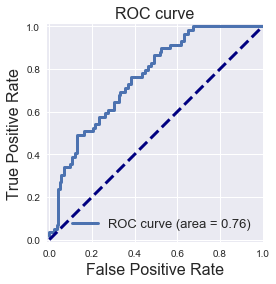

In [94]:
print('Grid best parameter (max. roc_auc): ', clf.best_params_)
print('Grid best score (roc_auc): ', clf.best_score_)
print(classification_report(y_test,clf.predict(df_test)))
plot_utils.plot_roc_curve(clf, df_test, y_test)

no improvement

In [95]:
clf.best_estimator_.named_steps['rnd_forest'].feature_importances_

array([ 0.00560883,  0.05214608,  0.00711015,  0.10847387,  0.0170766 ,
        0.05314603,  0.01077153,  0.00480139,  0.00897651,  0.00654667,
        0.00482131,  0.00168191,  0.00487747,  0.007829  ,  0.        ,
        0.00541948,  0.00576348,  0.02803811,  0.01211701,  0.00633868,
        0.        ,  0.00292834,  0.00495328,  0.00312619,  0.01269532,
        0.00535399,  0.01696271,  0.01041326,  0.00432915,  0.00095803,
        0.00302852,  0.01517293,  0.00519024,  0.00228587,  0.01016622,
        0.00507256,  0.00801404,  0.01106112,  0.00403472,  0.        ,
        0.01413111,  0.01081966,  0.00171526,  0.00205789,  0.00244057,
        0.        ,  0.00069404,  0.00618385,  0.        ,  0.00418719,
        0.00125675,  0.01658952,  0.00086114,  0.00093845,  0.06557264,
        0.0322018 ,  0.034333  ,  0.03945751,  0.0778511 ,  0.02179244,
        0.05258806,  0.04052745,  0.02560506,  0.01110812,  0.00509856,
        0.00703535,  0.02161915,  0.02604368])

In [96]:
feature_names = dict_vect.feature_names_ + numerical_features + int_features + ordinal_features
feature_importances = clf.best_estimator_.named_steps['rnd_forest'].feature_importances_
importance_idx = np.argsort(abs(feature_importances))[::-1]
[feature_names[idx] for idx in importance_idx if feature_importances[idx] > 0]
# print(len(feature_names))
# print(len(importance_idx))

["checking_status='no checking'",
 'log_duration',
 'duration',
 "credit_history='critical/other existing credit'",
 'log_age',
 "checking_status='<0'",
 'log_credit_duration_ratio',
 'credit_duration_ratio',
 'age',
 'credit_amount',
 'housing=own',
 'employment_ord',
 'installment_commitment',
 'log_credit_amount',
 'savings_status_ord',
 "credit_history='all paid'",
 'other_payment_plans=bank',
 "savings_status='<100'",
 "personal_status='female div/dep/mar'",
 "purpose='new car'",
 'other_parties=guarantor',
 'housing=rent',
 'residence_since',
 "property_magnitude='real estate'",
 "purpose='used car'",
 "credit_history='delayed previously'",
 'other_payment_plans=none',
 "personal_status='male single'",
 "credit_history='no credits/all paid'",
 "property_magnitude='no known property'",
 'employment=unemployed',
 "checking_status='>=200'",
 'num_dependents',
 "employment='1<=X<4'",
 "job='high qualif/self emp/mgmt'",
 'purpose=repairs',
 "housing='for free'",
 "checking_status='0<=

However we can see that these 2 new features are in the top 15 

Lets try adding the categorized continous features as new features:

In [ ]:
numericals_cat_features = []
for feature in numerical_features[:len(numerical_features)//2]: # /2 because we want to categorize only the original features,
# not the log of them
    df_train[feature + '_cat'], bins = pd.qcut(df_train[feature],4, retbins=True)
    df_train[feature + '_cat'] = df_train[feature + '_cat'].astype(str)
    df_test[feature + '_cat'] = pd.cut(df_test[feature],bins=bins)
    df_test[feature + '_cat'] = df_test[feature + '_cat'].astype(str)
    numericals_cat_features += [feature + '_cat']
num_cat_dict = df_train[numericals_cat_features].to_dict('records')
dict_vect_num = DictVectorizer(sparse = False)
num_cat_train = dict_vect_num.fit_transform(num_cat_dict)
X_train = np.hstack((X_train, num_cat_train))

num_cat_dict = df_test[numericals_cat_features].to_dict('records')
num_cat_test = dict_vect_num.transform(num_cat_dict)
X_test = np.hstack((X_test, num_cat_test))

We expect to get 76 (the former number of features) + 4 * 4 = 92 feauters. (4*4 becuase we categorize into quartiles and there is 4 numerical features):

In [132]:
feature_names = dict_vect.feature_names_ + one_hot_names + numerical_features + dict_vect_num.feature_names_
print(len(feature_names))
print(feature_names)

92
["checking_status='0<=X<200'", "checking_status='<0'", "checking_status='>=200'", "checking_status='no checking'", "credit_history='all paid'", "credit_history='critical/other existing credit'", "credit_history='delayed previously'", "credit_history='existing paid'", "credit_history='no credits/all paid'", "employment='1<=X<4'", "employment='4<=X<7'", "employment='<1'", "employment='>=7'", 'employment=unemployed', 'foreign_worker=no', 'foreign_worker=yes', "housing='for free'", 'housing=own', 'housing=rent', "job='high qualif/self emp/mgmt'", "job='unemp/unskilled non res'", "job='unskilled resident'", 'job=skilled', "other_parties='co applicant'", 'other_parties=guarantor', 'other_parties=none', 'other_payment_plans=bank', 'other_payment_plans=none', 'other_payment_plans=stores', 'own_telephone=none', 'own_telephone=yes', "personal_status='female div/dep/mar'", "personal_status='male div/sep'", "personal_status='male mar/wid'", "personal_status='male single'", "property_magnitude='

In [131]:
X_train.shape

(800, 92)

Yes. we got 92. Now lets try lr on the new data:

train auc score:  0.850681789503
train f1-score:  0.531764705882
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       559
          1       0.61      0.47      0.53       241

avg / total       0.74      0.75      0.74       800

[[488  71]
 [128 113]]
test auc score:  0.796970789758
test f1-score:  0.484848484848
             precision    recall  f1-score   support

          0       0.78      0.89      0.83       141
          1       0.60      0.41      0.48        59

avg / total       0.73      0.74      0.73       200

[[125  16]
 [ 35  24]]


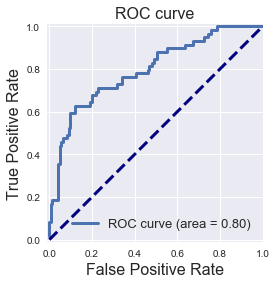

In [133]:
model = LogisticRegression(C = 10000, random_state=42) 
model.fit(X_train, y_train)

y_train_score = model.decision_function(X_train)
print('train auc score: ', roc_auc_score(y_train, y_train_score))
print('train f1-score: ', f1_score(y_train, pred_train))
print(classification_report(y_train, pred_train))
print(confusion_matrix(y_train, pred_train))

y_test_score = model.decision_function(X_test)
print('test auc score: ', roc_auc_score(y_test, y_test_score))
print('test f1-score: ', f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

plot_utils.plot_roc_curve(model, X_test, y_test)

Ok, now the over-fitting is well seen. So the one-hot encoding was the opening shot and now with the addition of of the above categoricals features the over-fitiing is clear... So:
### It seems that with the given amount of data a roc-auc of 0.82-3 is the best we can get.

Though we have over-fitiing it is interesting to see if the new features are in the top 20:

In [135]:
importance_idx = np.argsort(abs(model.coef_[0]))[::-1]
[feature_names[idx] for idx in importance_idx[:20]]

['purpose=retraining',
 'purpose=education',
 'log_duration',
 "credit_history='critical/other existing credit'",
 "purpose='used car'",
 "checking_status='no checking'",
 "job='unemp/unskilled non res'",
 'foreign_worker=no',
 "checking_status='<0'",
 'credit_amount_cat=(2333.0, 4154.5]',
 "credit_history='no credits/all paid'",
 'log_credit_amount',
 'log_age',
 'other_parties=guarantor',
 "purpose='new car'",
 'credit_amount_cat=(249.999, 1380.0]',
 "savings_status='>=1000'",
 'duration_cat=(3.999, 12.0]',
 'foreign_worker=yes',
 "personal_status='male single'"]

Yes, 3 of them